In [2]:
import jax
import jaxlib

print("jax version:", jax.__version__)
print("jaxlib version:", jaxlib.__version__)

import scvi
import h5py
import scanpy as sc
import anndata as ad
import pandas as pd
import scipy.sparse as sp
import numpy as np

jax version: 0.4.35
jaxlib version: 0.4.35


/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/scvi-env/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing CSRDataset from `anndata.expe

In [2]:


imputed_splicing_estimates = pd.read_hdf("imputed_dfs.h5", key="imputed_splicing_estimates")
imputed_expression_estimates = pd.read_hdf("imputed_dfs.h5", key="imputed_expression_estimates")

                     0         1         2         3         4         5    6  \
cell_id_for_index                                                               
A1_B000826         0.5  0.722544  0.500000  0.500000  0.760712  0.500000  0.5   
A1_B001176         0.5  0.501539  0.500000  0.500000  0.747961  0.500000  0.5   
A1_B003279         0.5  0.647028  0.500000  0.500000  0.857525  0.500000  0.5   
A1_B003281         0.5  0.709940  0.500000  0.500000  0.739297  0.500000  0.5   
A1_B003290         0.5  0.584208  0.531557  0.500000  0.707523  0.500000  0.5   
...                ...       ...       ...       ...       ...       ...  ...   
P9_B003921         0.5  0.847892  0.526712  0.587625  0.651583  0.500899  0.5   
P9_D045315         0.5  0.645976  0.500000  0.500000  0.737857  0.500000  0.5   
P9_D045318         0.5  0.592639  0.500000  0.500000  0.649552  0.500000  0.5   
P9_D045372         0.5  0.553916  0.517337  0.500000  0.930621  0.500000  0.5   
P9_D045853         0.5  0.71

In [10]:

from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=1)

as_pc1 = pca.fit_transform(imputed_splicing_estimates).flatten()
print(as_pc1.shape)
ge_pc1 = pca.fit_transform(imputed_expression_estimates).flatten()
print(ge_pc1.shape)

correlation = np.corrcoef(as_pc1, ge_pc1)[0, 1]
print(f"Correlation between PC1 of splicing and expression: {correlation:.4f}")



(19942,)
(19942,)
Correlation between PC1 of splicing and expression: -0.3159


In [3]:
combined_adata = ad.read_h5ad('/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad', backed = "r")
print(combined_adata)


AnnData object with n_obs × n_vars = 19942 × 77042 backed at '/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad'
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels', 'age', 'sex', 'cell_type_grouped', 'cell_ontology_class'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'GE_X_umap', 'X_multivi'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'


In [14]:
import anndata as ad
import pandas as pd
import numpy as np

combined_adata = ad.read_h5ad(
    "/home/sv2785/research_folder/ann_data/MULTIVI_TMS_BRAINONLY_Combined_GE_ATSE.h5ad", backed="r"
)

n_genes = imputed_expression_estimates.shape[1]
n_splicing = imputed_splicing_estimates.shape[1]

gene_expression_corr = []
splicing_corr = []

for i in range(combined_adata.n_obs):
    row = combined_adata[i, :].X.toarray().flatten() if combined_adata.isbacked else combined_adata[i, :].X.flatten()
    row_gene_expression = row[:n_genes]
    row_splicing = row[n_genes:n_genes + n_splicing]
    imputed_gene_expression = imputed_expression_estimates.iloc[i].values
    imputed_splicing = imputed_splicing_estimates.iloc[i].values
    gene_corr = np.corrcoef(row_gene_expression, imputed_gene_expression)[0, 1]
    splicing_corr_value = np.corrcoef(row_splicing, imputed_splicing)[0, 1]
    gene_expression_corr.append(gene_corr)
    splicing_corr.append(splicing_corr_value)

gene_expression_corr = pd.Series(gene_expression_corr, index=combined_adata.obs.index, name="Gene Expression Correlation")
splicing_corr = pd.Series(splicing_corr, index=combined_adata.obs.index, name="Splicing Correlation")


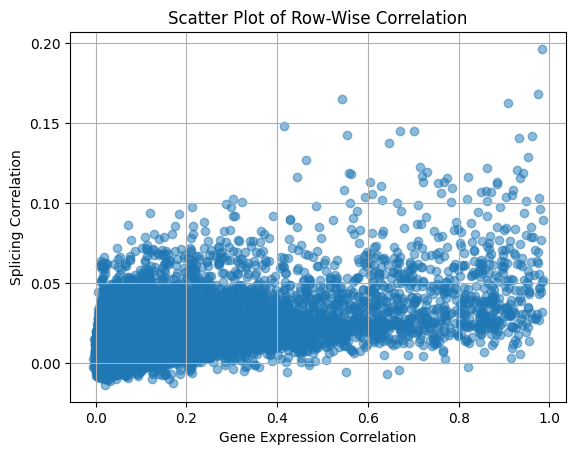

In [15]:
import matplotlib.pyplot as plt

plt.scatter(gene_expression_corr, splicing_corr, alpha=0.5)
plt.title("Scatter Plot of Row-Wise Correlation")
plt.xlabel("Gene Expression Correlation")
plt.ylabel("Splicing Correlation")
plt.grid(True)
plt.show()


In [16]:
print(np.mean(gene_expression_corr))
print(np.mean(splicing_corr))

0.12250414861618902
0.018030958525629113


In [18]:
print(combined_adata.obsm['X_multivi'])

[[-0.38143587 -0.34279865 -0.12188579 ... -0.4010613  -0.215687
  -1.0685703 ]
 [-0.28398383 -0.3798613  -0.08058798 ... -0.90297616 -0.37741438
  -1.0673724 ]
 [-0.37152615 -0.17086738 -0.04803129 ... -0.59711015 -0.23261808
  -0.88624096]
 ...
 [-0.5727163  -0.163072   -0.36292192 ... -0.41638932 -0.03031085
  -1.1944807 ]
 [-0.53255916 -0.32753593 -0.07681026 ... -0.17489715 -0.36156535
   0.08172578]
 [-0.1787365  -0.41945297 -0.04546402 ... -0.790117   -0.32799497
  -1.0947158 ]]


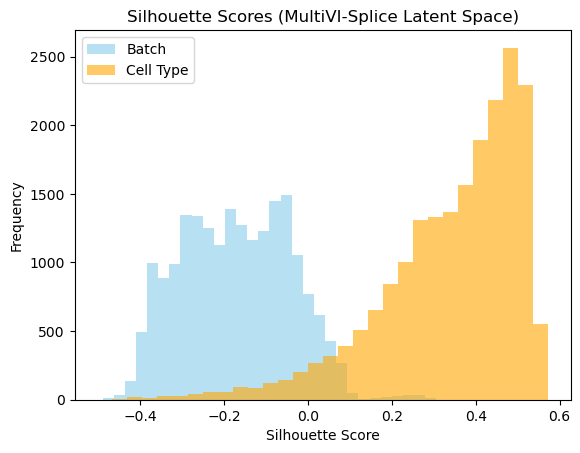

In [6]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd


latent_space = combined_adata.obsm['X_multivi']

# batch silhouette
batch_labels = combined_adata.obs['mouse.id']
batch_silhouette = silhouette_samples(latent_space, batch_labels)

# cell type silhouette
cell_type_labels = combined_adata.obs['cell_type_grouped']
cell_type_silhouette = silhouette_samples(latent_space, cell_type_labels)

silhouette_df = pd.DataFrame({
    'Batch Silhouette': batch_silhouette,
    'Cell Type Silhouette': cell_type_silhouette
}, index=combined_adata.obs.index)

import matplotlib.pyplot as plt

plt.hist(silhouette_df['Batch Silhouette'], bins=30, alpha=0.6, label="Batch", color="skyblue")
plt.hist(silhouette_df['Cell Type Silhouette'], bins=30, alpha=0.6, label="Cell Type", color="orange")
plt.legend()
plt.title("Silhouette Scores (MultiVI-Splice Latent Space)")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.show()


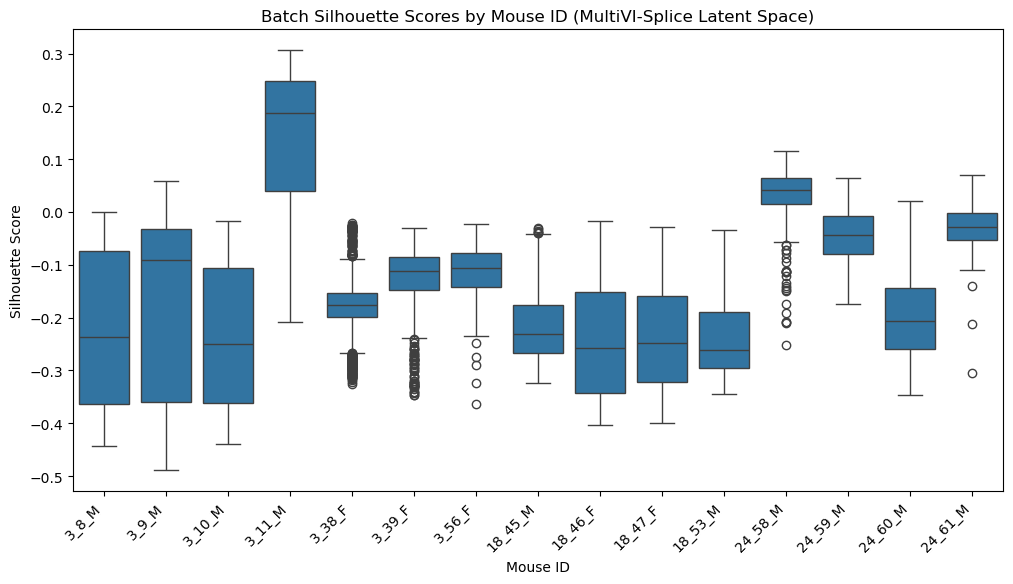

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Batch Silhouette'] = batch_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='mouse.id', y='Batch Silhouette', data=combined_adata.obs)
plt.title('Batch Silhouette Scores by Mouse ID (MultiVI-Splice Latent Space)')
plt.xlabel('Mouse ID')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


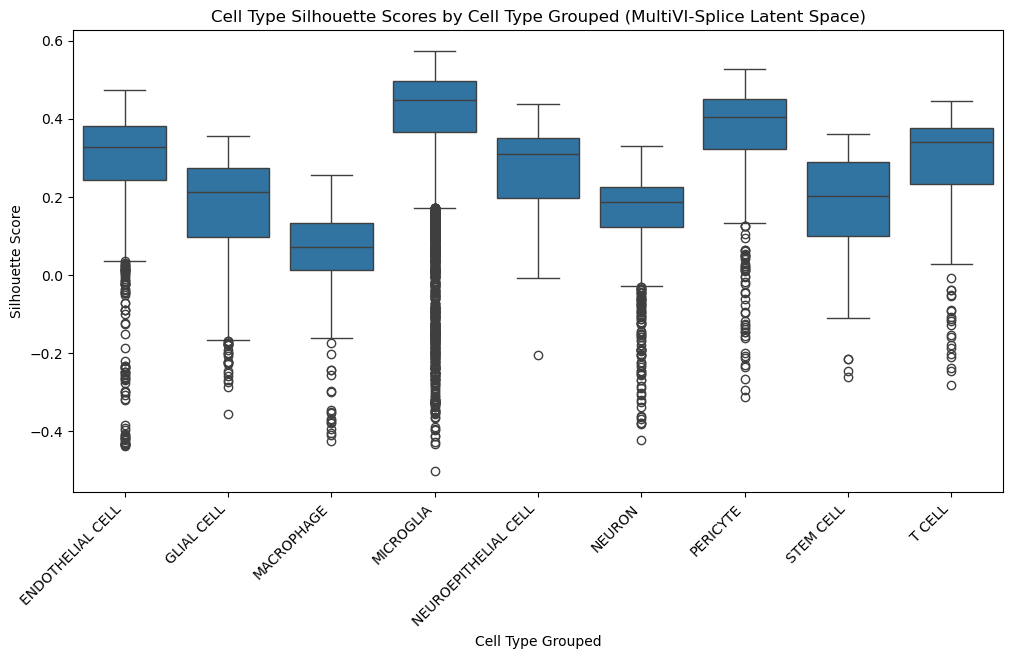

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Cell Type Silhouette'] = cell_type_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type_grouped', y='Cell Type Silhouette', data=combined_adata.obs)
plt.title('Cell Type Silhouette Scores by Cell Type Grouped (MultiVI-Splice Latent Space)')
plt.xlabel('Cell Type Grouped')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


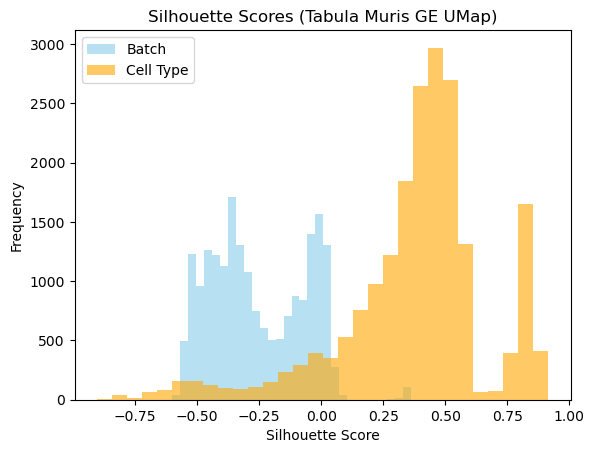

In [9]:
from sklearn.metrics import silhouette_samples
import numpy as np
import pandas as pd


latent_space = combined_adata.obsm['GE_X_umap']

# batch silhouette
batch_labels = combined_adata.obs['mouse.id']
batch_silhouette = silhouette_samples(latent_space, batch_labels)

# cell type silhouette
cell_type_labels = combined_adata.obs['cell_type_grouped']
cell_type_silhouette = silhouette_samples(latent_space, cell_type_labels)

silhouette_df = pd.DataFrame({
    'Batch Silhouette': batch_silhouette,
    'Cell Type Silhouette': cell_type_silhouette
}, index=combined_adata.obs.index)

import matplotlib.pyplot as plt

plt.hist(silhouette_df['Batch Silhouette'], bins=30, alpha=0.6, label="Batch", color="skyblue")
plt.hist(silhouette_df['Cell Type Silhouette'], bins=30, alpha=0.6, label="Cell Type", color="orange")
plt.legend()
plt.title("Silhouette Scores (Tabula Muris GE UMap)")
plt.xlabel("Silhouette Score")
plt.ylabel("Frequency")
plt.show()


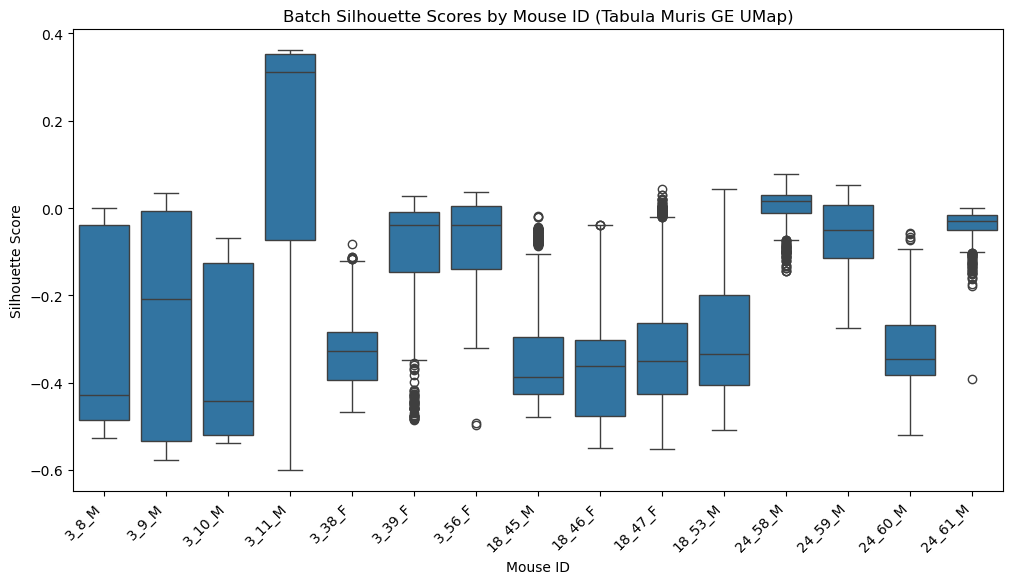

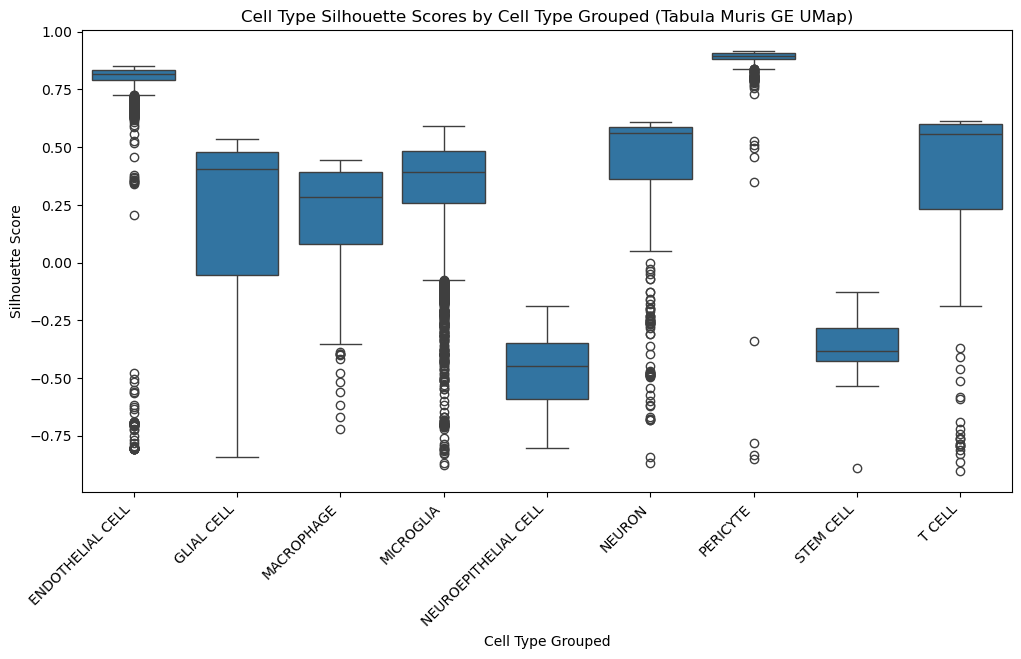

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Batch Silhouette_GE'] = batch_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='mouse.id', y='Batch Silhouette_GE', data=combined_adata.obs)
plt.title('Batch Silhouette Scores by Mouse ID (Tabula Muris GE UMap)')
plt.xlabel('Mouse ID')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

combined_adata.obs['Cell Type Silhouette_GE'] = cell_type_silhouette

plt.figure(figsize=(12, 6))
sns.boxplot(x='cell_type_grouped', y='Cell Type Silhouette_GE', data=combined_adata.obs)
plt.title('Cell Type Silhouette Scores by Cell Type Grouped (Tabula Muris GE UMap)')
plt.xlabel('Cell Type Grouped')
plt.ylabel('Silhouette Score')
plt.xticks(rotation=45, ha='right')
plt.show()


In [11]:
combined_adata.obs

,batch_id,modality,mouse.id,_indices,_scvi_batch,_scvi_labels,age,sex,cell_type_grouped,cell_ontology_class,Batch Silhouette,Cell Type Silhouette,Batch Silhouette_GE,Cell Type Silhouette_GE
cell_id_for_index,,,,,,,,,,,,,,
A1_B000826,1,paired,3_39_F,0,11,0,3m,female,MICROGLIA,microglial cell,-0.100823,0.492325,0.024797,0.341324
A1_B001176,1,paired,3_56_F,1,12,0,3m,female,MICROGLIA,microglial cell,-0.137037,0.541365,-0.098315,0.369918
A1_B003279,1,paired,3_38_F,2,10,0,3m,female,MICROGLIA,microglial cell,-0.172450,0.441626,-0.377248,0.417300
A1_B003281,1,paired,3_39_F,3,11,0,3m,female,MICROGLIA,microglial cell,-0.108430,0.449759,-0.027261,0.359983
A1_B003290,1,paired,3_38_F,4,10,0,3m,female,GLIAL CELL,ependymal cell,-0.150531,-0.115163,-0.224432,-0.631236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9_B003921,1,paired,24_59_M,19937,5,0,24m,male,MICROGLIA,microglial cell,-0.057244,0.223639,-0.085864,0.370313
P9_D045315,1,paired,18_45_M,19938,0,0,18m,male,MICROGLIA,microglial cell,-0.255423,0.490179,-0.389950,-0.018086
P9_D045318,1,paired,18_45_M,19939,0,0,18m,male,MICROGLIA,microglial cell,-0.207414,0.373815,-0.351936,0.473900


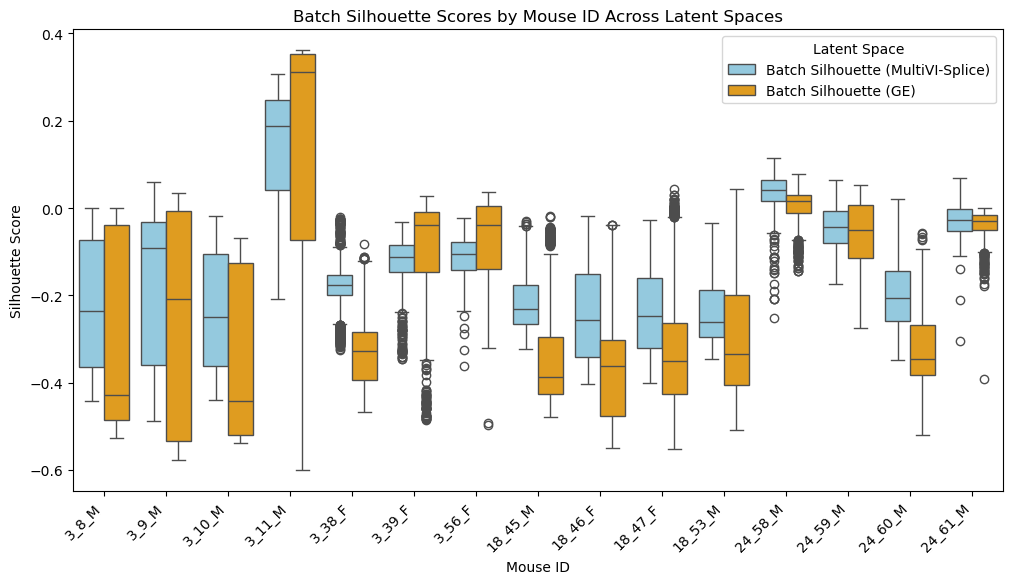

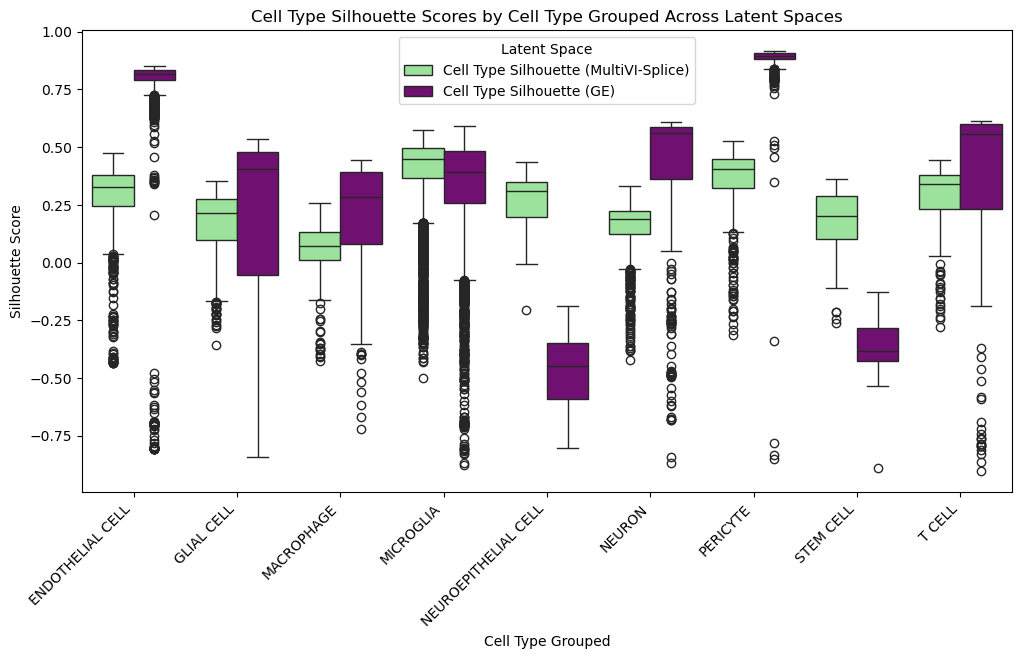

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Silhouette data
batch_silhouette = combined_adata.obs['Batch Silhouette']
batch_silhouette_ge = combined_adata.obs['Batch Silhouette_GE']
cell_type_silhouette = combined_adata.obs['Cell Type Silhouette']
cell_type_silhouette_ge = combined_adata.obs['Cell Type Silhouette_GE']
mouse_ids = combined_adata.obs['mouse.id']
cell_type_grouped = combined_adata.obs['cell_type_grouped']

# Data for Batch Silhouette
batch_data = pd.DataFrame({
    "Batch Silhouette (MultiVI-Splice)": batch_silhouette,
    "Batch Silhouette (GE)": batch_silhouette_ge,
    "Mouse ID": mouse_ids
})

batch_long_data = pd.melt(
    batch_data,
    id_vars="Mouse ID",
    value_vars=["Batch Silhouette (MultiVI-Splice)", "Batch Silhouette (GE)"],
    var_name="Latent Space",
    value_name="Silhouette Score"
)

# Data for Cell Type Silhouette
cell_type_data = pd.DataFrame({
    "Cell Type Silhouette (MultiVI-Splice)": cell_type_silhouette,
    "Cell Type Silhouette (GE)": cell_type_silhouette_ge,
    "Cell Type Grouped": cell_type_grouped
})

cell_type_long_data = pd.melt(
    cell_type_data,
    id_vars="Cell Type Grouped",
    value_vars=["Cell Type Silhouette (MultiVI-Splice)", "Cell Type Silhouette (GE)"],
    var_name="Latent Space",
    value_name="Silhouette Score"
)

# Plot for Batch Silhouette
plt.figure(figsize=(12, 6))
sns.boxplot(x="Mouse ID", y="Silhouette Score", hue="Latent Space", data=batch_long_data, palette=["skyblue", "orange"])
plt.title("Batch Silhouette Scores by Mouse ID Across Latent Spaces")
plt.xlabel("Mouse ID")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Latent Space")
plt.show()

# Plot for Cell Type Silhouette
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cell Type Grouped", y="Silhouette Score", hue="Latent Space", data=cell_type_long_data, palette=["lightgreen", "purple"])
plt.title("Cell Type Silhouette Scores by Cell Type Grouped Across Latent Spaces")
plt.xlabel("Cell Type Grouped")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Latent Space")
plt.show()


In [16]:
from scipy.stats import ttest_ind
import pandas as pd

batch_results = []
cell_type_results = []

for mouse_id in combined_adata.obs['mouse.id'].unique():
    batch_scores_1 = combined_adata.obs.loc[
        (combined_adata.obs['mouse.id'] == mouse_id), 'Batch Silhouette'
    ]
    batch_scores_2 = combined_adata.obs.loc[
        (combined_adata.obs['mouse.id'] == mouse_id), 'Batch Silhouette_GE'
    ]
    t_stat, p_value = ttest_ind(batch_scores_1, batch_scores_2, equal_var=False)
    effect_size = abs(batch_scores_1.mean() - batch_scores_2.mean())
    lower_group = "GE+Splice" if batch_scores_1.mean() < batch_scores_2.mean() else "GE"
    batch_results.append({
        "Mouse ID": mouse_id,
        "t-statistic": t_stat,
        "p-value": p_value,
        "Effect Size": effect_size,
        "Better Mixed": lower_group
    })

for cell_type in combined_adata.obs['cell_type_grouped'].unique():
    cell_scores_1 = combined_adata.obs.loc[
        (combined_adata.obs['cell_type_grouped'] == cell_type), 'Cell Type Silhouette'
    ]
    cell_scores_2 = combined_adata.obs.loc[
        (combined_adata.obs['cell_type_grouped'] == cell_type), 'Cell Type Silhouette_GE'
    ]
    t_stat, p_value = ttest_ind(cell_scores_1, cell_scores_2, equal_var=False)
    effect_size = abs(cell_scores_1.mean() - cell_scores_2.mean())
    higher_group = "GE+Splice" if cell_scores_1.mean() > cell_scores_2.mean() else "GE"
    cell_type_results.append({
        "Cell Type Grouped": cell_type,
        "t-statistic": t_stat,
        "p-value": p_value,
        "Effect Size": effect_size,
        "Better Clustered": higher_group
    })

batch_results_df = pd.DataFrame(batch_results)
cell_type_results_df = pd.DataFrame(cell_type_results)

print("Batch-Level T-Test Results:")
print(batch_results_df)

print("\nCell Type-Level T-Test Results:")
print(cell_type_results_df)



Batch-Level T-Test Results:
   Mouse ID  t-statistic        p-value  Effect Size Better Mixed
0    3_39_F    -7.431273   1.784388e-13     0.030840    GE+Splice
1    3_56_F    -6.828847   2.192353e-11     0.038713    GE+Splice
2    3_38_F    60.591626   0.000000e+00     0.152411           GE
3    3_10_M    22.490238  1.107915e-103     0.120155           GE
4     3_8_M     9.753523   5.849065e-22     0.075802           GE
5     3_9_M    12.488986   9.696584e-35     0.097808           GE
6    3_11_M     2.921952   3.754609e-03     0.067276           GE
7   18_53_M    12.409210   4.807883e-34     0.058905           GE
8   24_60_M    44.271239   0.000000e+00     0.134622           GE
9   18_47_F    21.884310  7.368408e-100     0.082306           GE
10  18_46_F    31.859795  2.106787e-200     0.114535           GE
11  24_61_M     6.855664   9.666887e-12     0.010882           GE
12  18_45_M    42.153052  2.477845e-305     0.130065           GE
13  24_58_M    16.802884   3.344645e-60     0.02